# Face Mask Detection with SVM and PCA

This notebook captures face images with and without masks, trains an SVM model, evaluates it, and then uses real-time webcam input to classify faces as wearing a mask or not.

In [1]:
import cv2 as cv
import numpy as np
import seaborn as sns
from sklearn.svm import SVC
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

C:\Users\44AU\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
pretrained = cv.CascadeClassifier('haarcascade_frontalface_default.xml')

## Step 1: Capture Mask Data

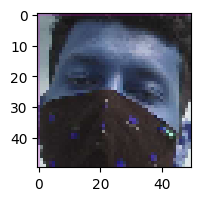

In [6]:


capture = cv.VideoCapture('http://192.168.1.6:8080/video')
data = []
while True:
    ret, img = capture.read()
    if ret:
        faces = pretrained.detectMultiScale(img)
        for x, y, w, h in faces:
            cv.rectangle(img, (x, y), (x + w, y + h), (255, 0, 255), 4)
            face = img[y:y + h, x:x + w, :]
            face = cv.resize(face, (50, 50))
            if len(data) < 400:
                data.append(face)
        cv.imshow('Mask Data', img)
        if cv.waitKey(2) == 27 or len(data) >= 200:
            break
capture.release()
cv.destroyAllWindows()
np.save('mask.npy', data)
plt.figure(figsize=(2,2))
plt.imshow(data[0])
plt.show()

## Step 2: Capture No Mask Data

In [7]:
capture = cv.VideoCapture('http://192.168.1.6:8080/video')
data = []
while True:
    ret, img = capture.read()
    if ret:
        faces = pretrained.detectMultiScale(img)
        for x, y, w, h in faces:
            cv.rectangle(img, (x, y), (x + w, y + h), (255, 0, 255), 4)
            face = img[y:y + h, x:x + w, :]
            face = cv.resize(face, (50, 50))
            if len(data) < 400:
                data.append(face)
        cv.imshow('No Mask Data', img)
        if cv.waitKey(2) == 27 or len(data) >= 200:
            break
capture.release()
cv.destroyAllWindows()

np.save('no_mask.npy', data)

plt.figure(figsize=(2,2))
plt.imshow(data[1])
plt.axis(False)
plt.show()

## Step 3: Load Data and Prepare Dataset

In [4]:
mask = np.load('mask.npy')
no_mask = np.load('no_mask.npy')

X = np.r_[no_mask, mask]
X = X.reshape(X.shape[0], -1)
Y = np.zeros(X.shape[0])
Y[no_mask.shape[0]:] = 1.0

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 320
Testing samples: 80


## Step 4: Apply PCA and Train SVM

In [5]:
pca = PCA(n_components=3)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

model = SVC()
model.fit(X_train, Y_train)

print(f"Model accuracy: {model.score(X_test, Y_test)}")

Model accuracy: 0.9875


## Step 5: Evaluate the Model

Accuracy Score: 0.9875
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99        48
         1.0       0.97      1.00      0.98        32

    accuracy                           0.99        80
   macro avg       0.98      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80



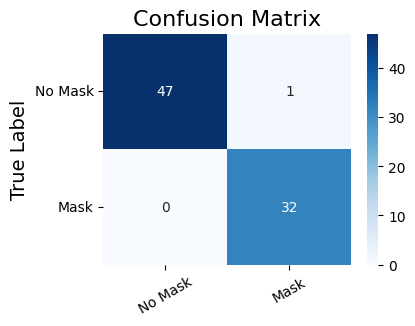

In [6]:
Y_pred = model.predict(X_test)
print("Accuracy Score:", accuracy_score(Y_test, Y_pred))
print("Classification Report:")
print(classification_report(Y_test, Y_pred))

cm = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, cmap='Blues', annot=True, fmt='g')
plt.xticks(ticks=[0.5,1.5], labels=['No Mask', 'Mask'], rotation=30)
plt.yticks(ticks=[0.5,1.5], labels=['No Mask', 'Mask'], rotation=0)
plt.ylabel('True Label', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

## Step 6: Real-Time Face Mask Detection

In [7]:
import winsound  # For playing sound on Windows

capture = cv.VideoCapture(0)
names = {0: 'No Mask', 1: 'Mask'}
font = cv.FONT_HERSHEY_COMPLEX

while True:
    ret, img = capture.read()
    if ret:
        faces = pretrained.detectMultiScale(img)
        for x, y, w, h in faces:
            face = img[y:y + h, x:x + w, :]
            face = cv.resize(face, (50, 50))
            face = face.reshape(1, -1)
            face = pca.transform(face)
            pred = model.predict(face)
            label_index = int(pred)
            label = names[label_index]

            # Draw rectangle with color based on label
            if label_index == 1:
                color = (0, 255, 0)  # Green for Mask
            else:
                color = (0, 0, 255)  # Red for No Mask
                winsound.Beep(1000, 500)  # Warning sound on Windows

            cv.rectangle(img, (x, y), (x + w, y + h), color, 4)
            cv.putText(img, label, (x, y), font, 1, (244, 250, 250), 2)
        cv.imshow('Real-Time Detection', img)
        if cv.waitKey(2) == 27:
            break

capture.release()
cv.destroyAllWindows()
